# **Практика 7: Создание и использование генеративных противоречивых примеров (GAN based Adversarial Examples)**

Выполнил студент 2 курса группы: **ББМО-02-23**

ФИО: **Курченко Иван Дмитриевич**

# **Цель задания:**
 Изучить использование генеративных моделей (**GAN — Generative Adversarial Networks**) для создания противоречивых примеров. В этом задании мы создадим противоречивые примеры с использованием **GAN** и проверим их влияние на модели классификации.

  Генеративные противоречивые примеры — это изображения, созданные генеративными моделями, которые могут обманывать модели классификации. В отличие от стандартных атак (например, **FGSM** или **PGD**), где добавляются малые шумы, **GAN** могут генерировать реалистичные, но сложные для распознавания модели изображения, которые сложно отличить от настоящих данных.

##**Шаги выполнения:**

### **Шаг 1: Концепция генеративных противоречивых примеров**

### **Шаг 1: Создание простой GAN для генерации противоречивых примеров**

 Мы создадим генеративную состязательную сеть (**GAN**), состоящую из двух частей: генератора и дискриминатора. Генератор будет создавать изображения, а дискриминатор — пытаться распознать поддельные изображения.

#### **1.1 - Загрузим нужные для работы библиотеки:**

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

#### **1.2 - Загрузим данные для работы из датасета MNIST:**

In [2]:
(train_images, _), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images / 255.0

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


#### **1.3 - Добавление дополнительного измерения для работы CNN:**

In [3]:
train_images = np.expand_dims(train_images, axis=-1)

#### **1.4 - Создадим генеративную состязательную сеть (GAN), состоящую из двух частей: генератора и дискриминатора. Генератор будет создавать изображения, а дискриминатор — пытаться распознать поддельные изображения.**

In [4]:
# Генератор:
def build_generator():
  model = tf.keras.Sequential()
  model.add(layers.Dense(128, activation='relu', input_dim=100))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())
  model.add(layers.Dense(784, activation='tanh'))
  model.add(layers.Reshape((28, 28, 1)))
  return model

# Дискриминатор:
def build_discriminator():
  model = tf.keras.Sequential()
  model.add(layers.Conv2D(64, (3, 3), padding='same', input_shape=(28, 28, 1)))
  model.add(layers.LeakyReLU())
  model.add(layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(layers.Flatten())
  model.add(layers.Dense(1, activation='sigmoid'))
  return model

# Создание моделей:
generator = build_generator()
discriminator = build_discriminator()

# Компиляция дискриминатора:
discriminator.compile(optimizer='adam', loss='binary_crossentropy',
metrics=['accuracy'])

# Создание GAN:
gan_input = layers.Input(shape=(100,))
generated_image = generator(gan_input)
discriminator.trainable = False
validity = discriminator(generated_image)
gan = tf.keras.Model(gan_input, validity)
gan.compile(optimizer='adam', loss='binary_crossentropy')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


#### **1.5 - Обучим полученную GAN сеть:**

In [5]:
# Функция обучения GAN:
def train_gan(generator, discriminator, gan, epochs=1000, batch_size=64):
  half_batch = batch_size // 2
  for epoch in range(epochs):
  # Обучение дискриминатора:
      idx = np.random.randint(0, train_images.shape[0], half_batch)
      real_images = train_images[idx]
      noise = np.random.normal(0, 1, (half_batch, 100))
      fake_images = generator.predict(noise)
      real_labels = np.ones((half_batch, 1))
      fake_labels = np.zeros((half_batch, 1))
      d_loss_real = discriminator.train_on_batch(real_images, real_labels)
      d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)
  # Обучение генератора через дискриминатор:
      noise = np.random.normal(0, 1, (batch_size, 100))
      valid_labels = np.ones((batch_size, 1))
      g_loss = gan.train_on_batch(noise, valid_labels)
      if epoch % 100 == 0:
        print(f'{epoch} [D loss: {0.5 * np.add(d_loss_real, d_loss_fake)}] [G loss: {g_loss}]')
# Обучение GAN:
train_gan(generator, discriminator, gan)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


0 [D loss: [0.6927427 0.4765625]] [G loss: [array(0.6918235, dtype=float32), array(0.6918235, dtype=float32), array(0.515625, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━

### **Шаг 2: Генерация противоречивых примеров с помощью обученной GAN**

Теперь мы сгенерируем противоречивые примеры, используя обученный генератор **GAN**:

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 256ms/step


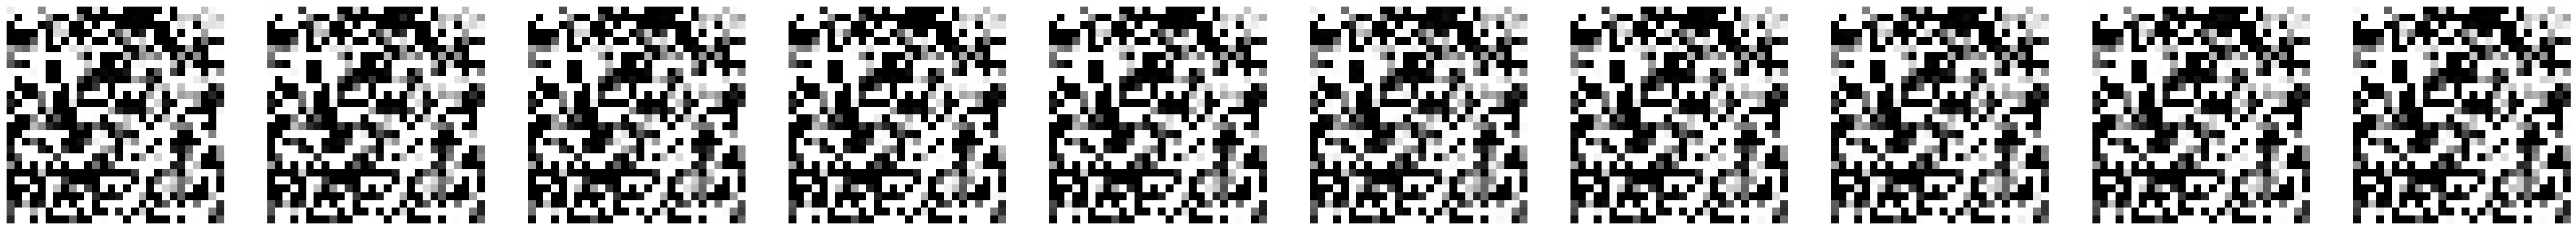

In [6]:
# Генерация противоречивых примеров:
def generate_adversarial_examples(generator, n_samples):
  noise = np.random.normal(0, 1, (n_samples, 100))
  generated_images = generator.predict(noise)
  return generated_images
# Генерация 100 примеров:
adversarial_images = generate_adversarial_examples(generator, 100)
# Визуализация противоречивых примеров:
plt.figure(figsize=(50, 50))
for i in range(10):
  plt.subplot(1, 10, i+1)
  plt.imshow(adversarial_images[i].reshape(28, 28), cmap='gray')
  plt.axis('off')
plt.show()

###**Шаг 3: Оценка моделей на противоречивых примерах**

 Теперь проверим, как обученные модели (**полносвязная сеть** и **CNN**) справляются с противоречивыми примерами, созданными с помощью **GAN**.

In [9]:
# Загрузка обученных моделей:
model1 = tf.keras.models.load_model('mnist_model_fc.h5')
model2 = tf.keras.models.load_model('mnist_model_с.h5')
# Оценка первой модели на противоречивых примерах:
adv_images_reshaped = adversarial_images.reshape(-1, 28, 28, 1)
loss1, acc1 = model1.evaluate(adv_images_reshaped, np.ones((100, 10)))
print(f'Accuracy of FC MNIST model on adversarial GAN examples: {acc1}')
# Оценка второй модели на противоречивых примерах:
loss2, acc2 = model2.evaluate(adv_images_reshaped, np.ones((100, 10)))
print(f'Accuracy of CNN MNIST model on adversarial GAN examples: {acc2}')

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 179.0125  
Accuracy of FC MNIST model on adversarial GAN examples: 0.0
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - loss: 395.6447  
Accuracy of CNN MNIST model on adversarial GAN examples: 0.0


### **Шаг 4: Анализ результатов**

Полносвязная модель показала потери 179.0125, а свёрточная модель — 395.6447. Эти высокие значения потерь свидетельствуют о том, что предсказания моделей значительно отклонились от истинных меток, что подтверждает их неспособность обрабатывать противоречивые примеры.

Эти выводы подчеркивают важность разработки более надежных систем машинного обучения и необходимость интеграции методов защиты в процесс обучения и оценки моделей.